In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dna-classification-dataset/synthetic_dna_dataset.csv


In [68]:
import pandas as pd 
import numpy as np 
import seaborn as sns
sns.set_theme(style='whitegrid')
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [69]:
df = pd.read_csv('/kaggle/input/dna-classification-dataset/synthetic_dna_dataset.csv')

In [70]:
df.head()

,Sample_ID,Sequence,GC_Content,AT_Content,Sequence_Length,Num_A,Num_T,Num_C,Num_G,kmer_3_freq,Mutation_Flag,Class_Label,Disease_Risk
0,SAMPLE_1,CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...,50.0,50.0,100,22,28,19,31,0.986,0,Bacteria,High
1,SAMPLE_2,TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...,45.0,55.0,100,27,28,22,23,0.486,1,Virus,Medium
2,SAMPLE_3,GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...,51.0,49.0,100,26,23,30,21,0.367,1,Bacteria,Low
3,SAMPLE_4,ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...,55.0,45.0,100,28,17,23,32,0.404,0,Human,Medium
4,SAMPLE_5,TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...,46.0,54.0,100,24,30,25,21,0.818,0,Human,High


In [71]:
df.drop(columns=['Sample_ID', 'Sequence_Length'], inplace = True)

In [72]:
df.rename(columns={'Num_A':'Adenine bases','Num_T':'Thymine bases','Num_C':'Cytosine bases','Num_G':'Guanine bases','Mutation_Flag':'DNA_Change','Class_Label':'Species','GC_Content':'Guanine/Cytosine %','AT_Content':'Adenine/Thymine %'}, inplace=True)

In [73]:
df.isnull().sum()

Sequence              0
Guanine/Cytosine %    0
Adenine/Thymine %     0
Adenine bases         0
Thymine bases         0
Cytosine bases        0
Guanine bases         0
kmer_3_freq           0
DNA_Change            0
Species               0
Disease_Risk          0
dtype: int64

In [75]:
df.duplicated().sum()

0

In [74]:
df.describe()

,Guanine/Cytosine %,Adenine/Thymine %,Adenine bases,Thymine bases,Cytosine bases,Guanine bases,kmer_3_freq,DNA_Change
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,50.120000,49.880000,24.950667,24.929333,25.004000,25.116000,0.547738,0.496667
std,5.062688,5.062688,4.317458,4.317702,4.349056,4.329603,0.258521,0.500072
min,34.000000,34.000000,11.000000,9.000000,10.000000,12.000000,0.100000,0.000000
25%,47.000000,47.000000,22.000000,22.000000,22.000000,22.000000,0.330000,0.000000
50%,50.000000,50.000000,25.000000,25.000000,25.000000,25.000000,0.543000,0.000000
75%,53.000000,53.000000,28.000000,28.000000,28.000000,28.000000,0.772250,1.000000
max,66.000000,66.000000,40.000000,42.000000,42.000000,42.000000,1.000000,1.000000


#EDA

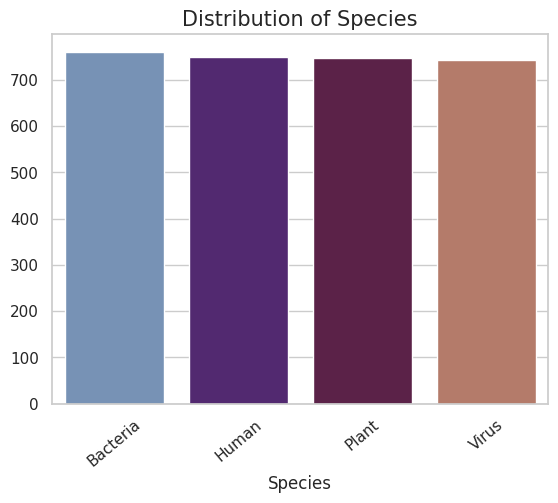

In [76]:
sns.barplot(x=df['Species'].value_counts().index,
            y=df['Species'].value_counts().values,
            palette='twilight')

plt.title('Distribution of Species', fontsize=15)
plt.xticks(rotation=40)
plt.show()

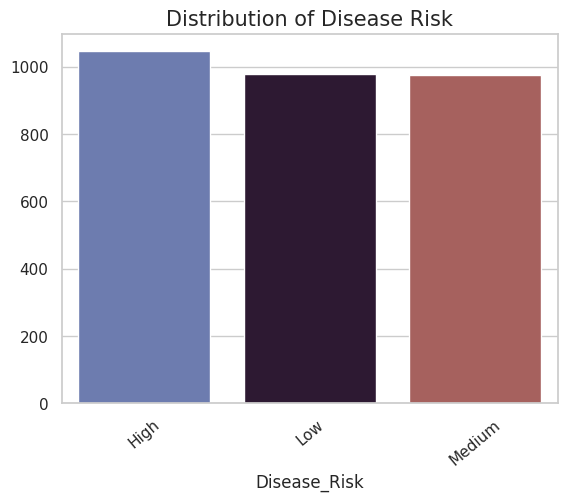

In [77]:
sns.barplot(x = df['Disease_Risk'].value_counts().index,
            y = df['Disease_Risk'].value_counts().values,
            palette='twilight')
plt.title('Distribution of Disease Risk', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

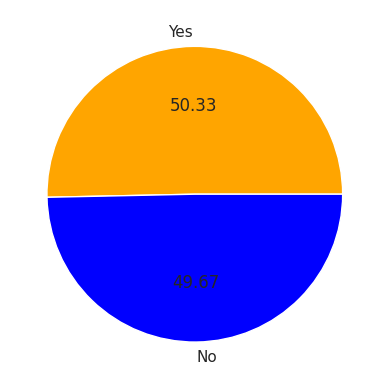

In [78]:
plt.pie(df['DNA_Change'].value_counts(normalize=True),autopct='%.2f',labels=['Yes','No'],colors=['orange','blue'],radius=1)
plt.show()

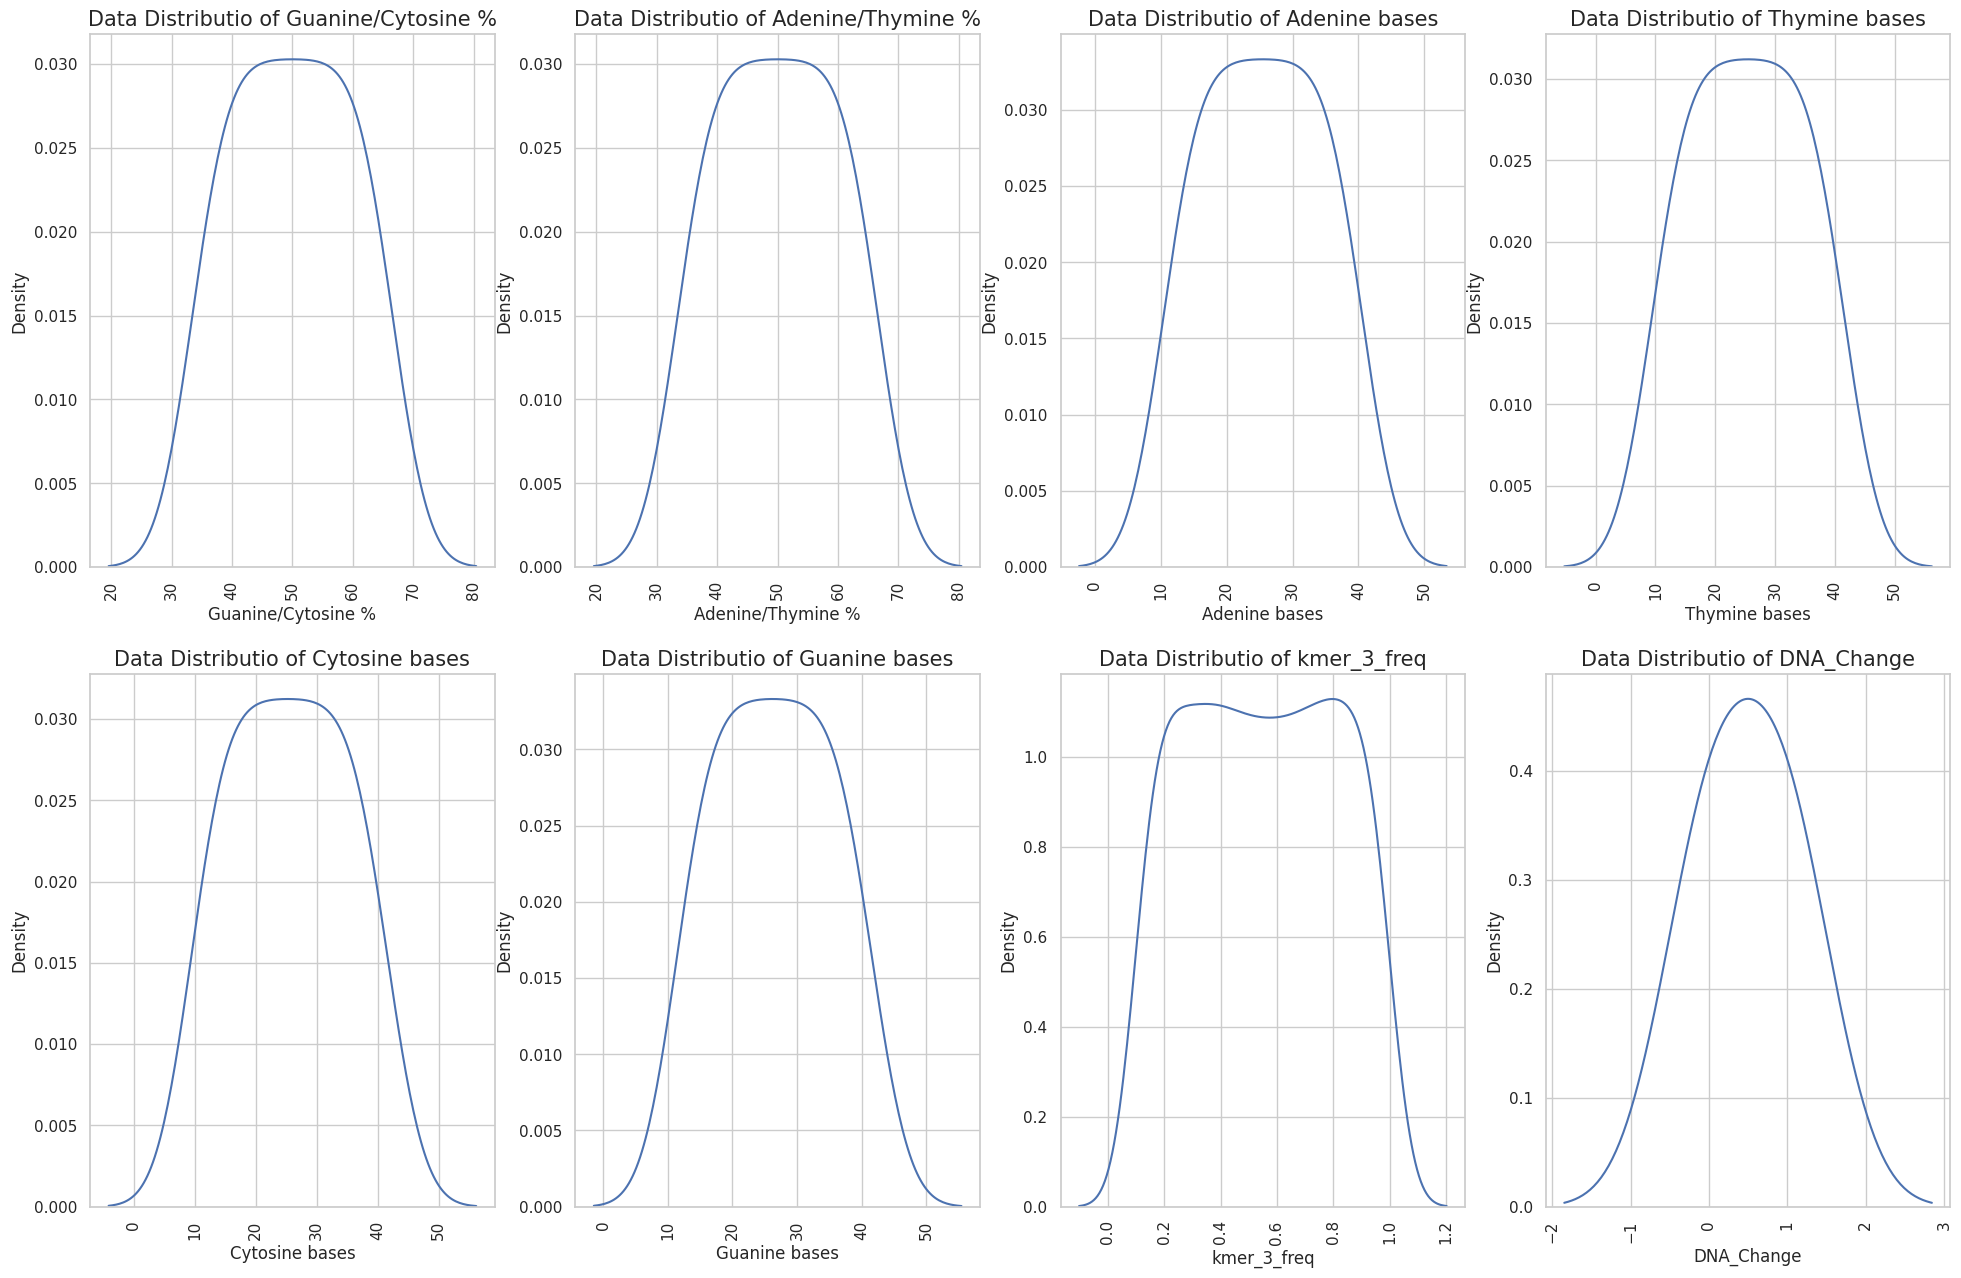

In [79]:
num_col = df.select_dtypes(include = 'number')
num_col

plt.figure(figsize=(24,90))
index = 1

for col in num_col:
  y = df[col].value_counts()
  plt.subplot(11,4,index)
  plt.title(f'Data Distributio of {col}', fontsize = 15)
  plt.xticks(rotation=90)
  plt.xlabel(col)
  sns.kdeplot(x=list(y.index))
  index +=1

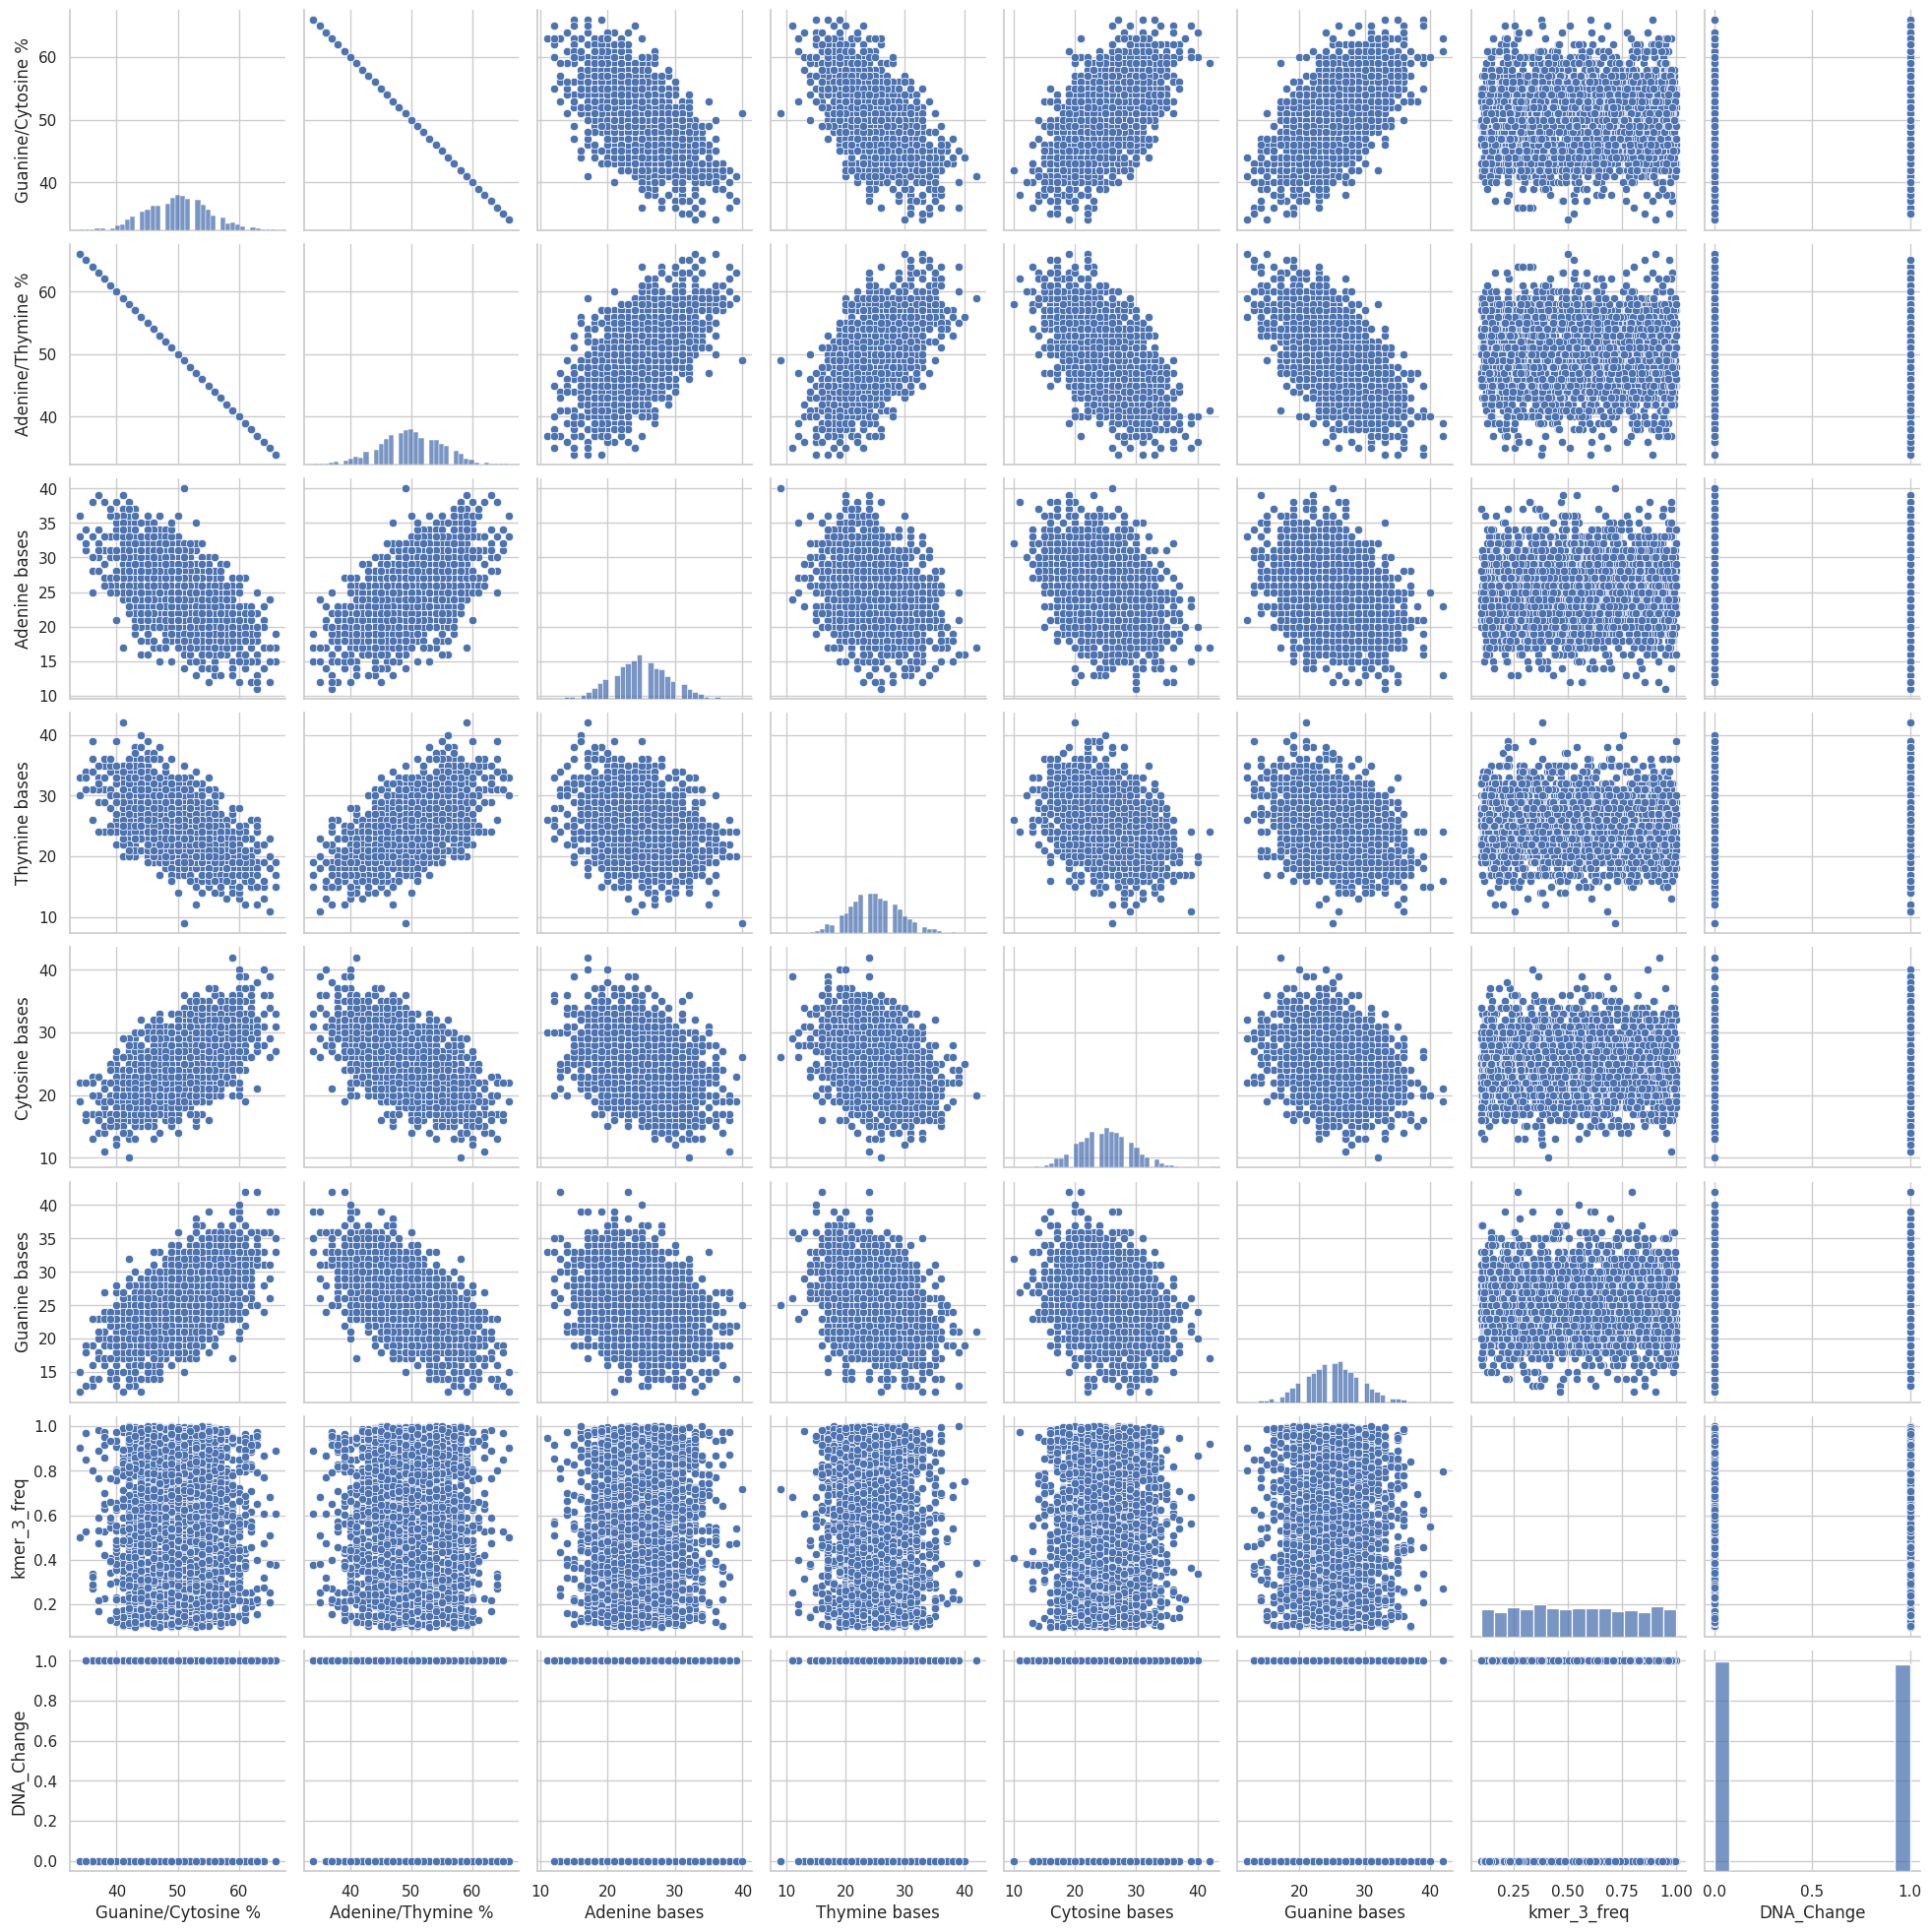

In [80]:
sns.pairplot(num_col)

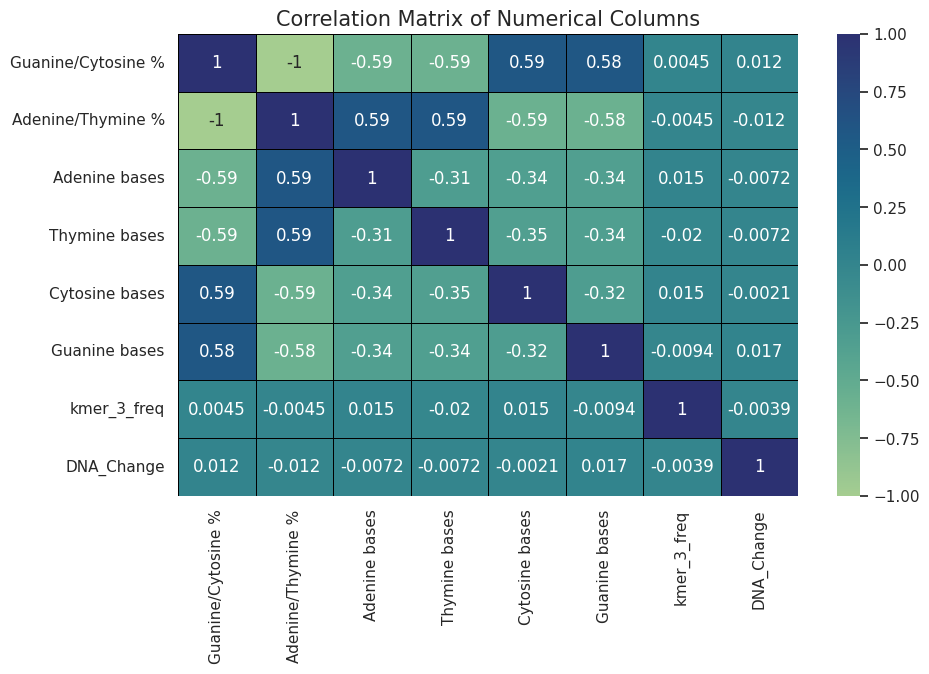

In [81]:
corr_matrix = num_col.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot = True, linewidth = 0.50, cmap='crest', linecolor='black')
plt.title('Correlation Matrix of Numerical Columns', fontsize = 15)
plt.show()

In [82]:
features = [
 'Guanine/Cytosine %',
 'Adenine/Thymine %',
 'Adenine bases',
 'Thymine bases',
 'Cytosine bases',
 'Guanine bases',
 'kmer_3_freq',
 'Species'
]

X = df[features]
y = df['DNA_Change']


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 8), (600, 8), (2400,), (600,))

In [84]:
numerical_col = ['Guanine/Cytosine %',
 'Adenine/Thymine %',
 'Adenine bases',
 'Thymine bases',
 'Cytosine bases',
 'Guanine bases',
 'kmer_3_freq']

numeric_transformer = Pipeline(steps=[
   ('scaler', StandardScaler())
])

In [85]:
cat_col = ['Species']

cat_transformer = Pipeline(steps=[
   ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [86]:
Preprocessor = ColumnTransformer(transformers=[
   ('numeric_transformer', numeric_transformer, numerical_col),
   ('cat_transformer', cat_transformer, cat_col)
])

In [87]:
model = Pipeline(steps=[
   ('preprocessing', Preprocessor),
   ('model', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced'))
])

In [88]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Guanine/Cytosine %',
                                                   'Adenine/Thymine %',
                                                   'Adenine bases',
                                                   'Thymine bases',
                                                   'Cytosine bases',
                                                   'Guanine bases',
                                                   'kmer_3_freq']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Species'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=300, random_state=42))])

In [89]:
y_pred = model.predict(X_test)

print('Accuracy Score : ', 100* accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score :  52.0
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       311
           1       0.50      0.55      0.53       289

    accuracy                           0.52       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.52      0.52      0.52       600

